# Two-Layer Neural Network

A two-layer NN with two inputs and one output is given by

$$ y = W^T \sigma(V^T x + b_v) + b_w $$

with weight matrices and thresholds/biases given by
$V^T = \begin{pmatrix} -2.69 & -2.80 \\ -3.39 & -4.56 \end{pmatrix}$
, $b_v = \begin{pmatrix} -2.21 \\ 4.76 \end{pmatrix}$
, $W = \begin{pmatrix} -4.91 \\ 4.95\end{pmatrix}$
, and $b_w = -2.28$.

For the inputs defined in the domain $[-2, 2] \times [-2, 2]$, we will plot the output surface $y$ as a function of $x1, x2$, when the activation function is (a) sigmoid (b) Hard limit and (c) Radial basis function.
The function will be plotted with $100$, $5{,}000$, $10{,}000$ sample points from the domain.


In [1]:
import numpy as np
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ensure the 'outputs' directory exists for saving images
if not os.path.exists("outputs"):
    os.makedirs("outputs")

In [2]:
# Define the two-layer NN's parameters
V_T = np.array([[-2.69, -2.80], [-3.39, -4.56]])
b_v = np.array([[-2.21], [4.76]])
W = np.array([[-4.91], [4.95]])
b_w = -2.28

# Define the input domain
domain_min = -2
domain_max = 2

# Define the sample sizes for plotting
sample_sizes = [100, 5000, 10000]

In [3]:
# Activation Functions
def sigmoid(z):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-z))


def hard_limit(z):
    """Hard limit activation function."""
    # Returns 1 if z >= 0, else 0.
    return (z >= 0).astype(int)


def gaussian_rbf(z, sigma_rbf=5.0):
    """
    Gaussian Radial Basis Function as an activation function.

    This function applies a Gaussian shape to the scalar linear combination 'z'.
    It assumes a center (mu) of 0.
    The 'sigma_rbf' parameter controls the width of the Gaussian.
    A larger sigma_rbf makes the Gaussian wider.
    """
    return np.exp(-(z**2) / (2 * sigma_rbf**2))


# Dictionary of activation functions
activation_functions = {
    "Sigmoid": sigmoid,
    "Hard Limit": hard_limit,
    "Gaussian RBF": gaussian_rbf,
}

In [4]:
def get_grid_dimensions(N_total):
    """
    Finds two integers nx, ny such that nx * ny = N_total,
    and nx, ny are as close to each other as possible.
    This ensures the total number of points is exactly N_total.
    """
    if N_total <= 0:
        raise ValueError("N_total must be positive")

    if N_total == 1:
        return 1, 1

    sqrt_N = int(np.sqrt(N_total))

    # Iterate downwards from sqrt_N to find the largest factor
    # This ensures nx is as close to ny as possible (nx <= ny)
    for i in range(sqrt_N, 0, -1):
        if N_total % i == 0:
            return i, N_total // i

    # This case should theoretically not be reached for N_total > 1,
    # as 1 is always a factor.
    return N_total, 1  # Fallback, e.g., for prime numbers, though 1 is always a factor.

In [5]:
def two_layer_nn_forward(x1_grid, x2_grid, activation_func, V_T, b_v, W, b_w):
    """
    Calculates the output of the two-layer neural network for a grid of inputs.

    :param x1_grid: 2D array of x1 values (from meshgrid).
    :param x2_grid: 2D array of x2 values (from meshgrid).
    :param activation_func: The activation function for the hidden layer.
    :param V_T: Transpose of the weight matrix for the first layer.
    :param b_v: Bias vector for the first layer.
    :param W: Weight vector for the second layer.
    :param b_w: Bias for the second layer.
    :return: The 2D array of output y values.
    """
    # Flatten the grids to process all points at once
    num_points_y, num_points_x = x1_grid.shape
    X1_flat = x1_grid.flatten()
    X2_flat = x2_grid.flatten()

    # Stack inputs into a (2, N_total) matrix
    X_input = np.vstack((X1_flat, X2_flat))  # Shape (2, N_total)

    # Hidden layer calculation: z_h = V_T @ x + b_v
    # V_T (2,2) @ X_input (2, N_total) -> (2, N_total)
    # b_v (2,1) broadcasts to (2, N_total)
    Z_h = np.dot(V_T, X_input) + b_v

    # Apply activation function to hidden layer
    A_h = activation_func(Z_h)  # Shape (2, N_total)

    # Output layer calculation: y = W.T @ a_h + b_w
    # W.T (1,2) @ A_h (2, N_total) -> (1, N_total)
    # b_w (scalar) broadcasts to (1, N_total)
    Y_flat = np.dot(W.T, A_h) + b_w

    # Reshape the output back to the original grid dimensions
    Y = Y_flat.reshape(num_points_y, num_points_x)

    return Y

In [8]:
# Loop through activation functions and sample sizes to generate plots
for act_name, act_func in activation_functions.items():
    # Determine a suitable z-axis range based on the activation function
    # These ranges are estimated based on the parameter values and activation function properties.
    if act_name == "Sigmoid" or act_name == "Gaussian RBF":
        # Hidden layer output is between 0 and 1.
        # W.T @ A_h is roughly between -4.91*1 + 4.95*0 = -4.91 and -4.91*0 + 4.95*1 = 4.95
        # Then add b_w (-2.28): roughly [-4.91 - 2.28, 4.95 - 2.28] = [-7.19, 2.67]
        z_range = [-8, 3]
    elif act_name == "Hard Limit":
        # Hidden layer output is 0 or 1.
        # W.T @ A_h can be 0, -4.91, 4.95, or 0.04.
        # Then add b_w (-2.28): roughly [-4.91 - 2.28, 4.95 - 2.28] = [-7.19, 2.67]
        z_range = [-8, 3]
    else:
        z_range = None  # Let Plotly auto-scale

    for N_samples in sample_sizes:
        # Use the helper function to get exact grid dimensions
        num_points_x, num_points_y = get_grid_dimensions(N_samples)

        # Generate grid points for x1 and x2
        x1_vals = np.linspace(domain_min, domain_max, num_points_x)
        x2_vals = np.linspace(domain_min, domain_max, num_points_y)
        X1, X2 = np.meshgrid(x1_vals, x2_vals)  # Create a meshgrid for 3D plotting

        # Calculate the output Y using the two-layer NN forward pass
        Y = two_layer_nn_forward(X1, X2, act_func, V_T, b_v, W, b_w)

        # Create a Plotly figure
        fig = go.Figure(data=[go.Surface(x=X1, y=X2, z=Y, colorscale="Viridis")])

        # Update layout for title and axis labels/limits
        fig.update_layout(
            title_text=f"Two-Layer NN Output Surface: {act_name} Activation ({N_samples} points)",
            scene=dict(
                xaxis_title=r"$x_1$",
                yaxis_title=r"$x_2$",
                zaxis_title=r"$y$",
                zaxis_range=z_range,  # Consistent z-axis limits for better comparison
            ),
            # Adjust figure size
            height=700,
            width=900,
        )

        # Display the interactive plot
        fig.show()

**Manual Step**: `Plotly` creates interactive 3D plots. We manually save each figure with the best looking angles and save to the `outputs` directory.

The following code block will combine these saved images into a single Matplotlib figure for easy comparison.


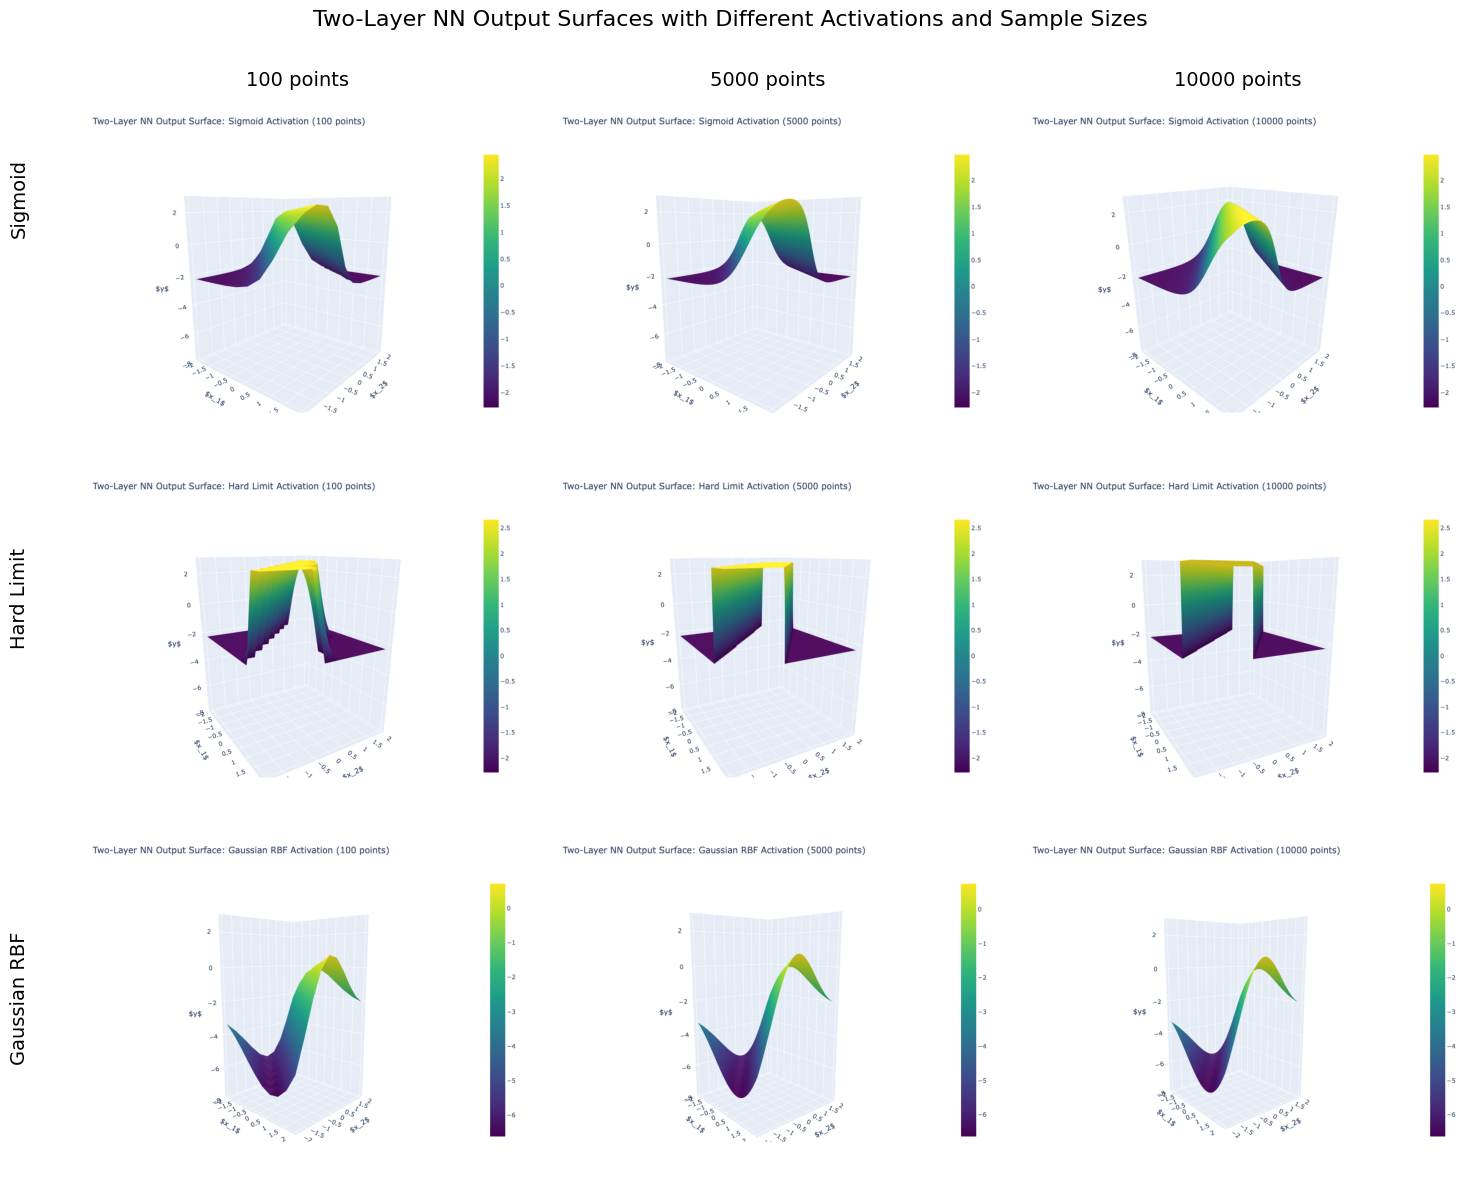

In [9]:
# Map filenames to display names
functions_map = {
    "sigmoid": "Sigmoid",
    "hard_limit": "Hard Limit",
    "rbf": "Gaussian RBF",
}
sample_sizes = [100, 5000, 10000]

# Create figure and axes grid
fig, axes = plt.subplots(
    nrows=len(functions_map), ncols=len(sample_sizes), figsize=(15, 12)
)

# Loop through functions and sample sizes
for i, (func_key, func_title) in enumerate(functions_map.items()):
    for j, n in enumerate(sample_sizes):
        ax = axes[i, j]

        # Load image
        img = mpimg.imread(f"outputs/two_layer_nn_{func_key}_{n}.png")
        ax.imshow(img)
        ax.axis("off")

        # Add column titles (top row only)
        if i == 0:
            ax.set_title(f"{n} points", fontsize=14, pad=10)

    # Place row label on the far left margin, centered for this row
    fig.text(
        0.02,  # x-position (left margin)
        (len(functions_map) - i - 0.5)
        / len(functions_map),  # y-position centered for row
        func_title,
        va="center",
        ha="left",
        rotation=90,
        fontsize=14,
    )

# Adjust layout
plt.tight_layout(rect=[0.05, 0, 1, 0.95])  # leave space for labels + title

# Main title
fig.suptitle(
    "Two-Layer NN Output Surfaces with Different Activations and Sample Sizes",
    fontsize=16,
    y=0.99,
)

# Save combined figure
plt.savefig("outputs/two_layer_nn_combined_figure.png", dpi=300, bbox_inches="tight")
plt.show()